In [13]:
from trips.testProblems import *
from pylops import Identity, LinearOperator
from trips.utils import operator_qr, operator_svd, is_identity
from trips.parameter_selection.gcv import *
import scipy.linalg as la
import numpy as np
from trips.solvers.Hybrid_GMRES import *
from trips.solvers.Hybrid_LSQR import *

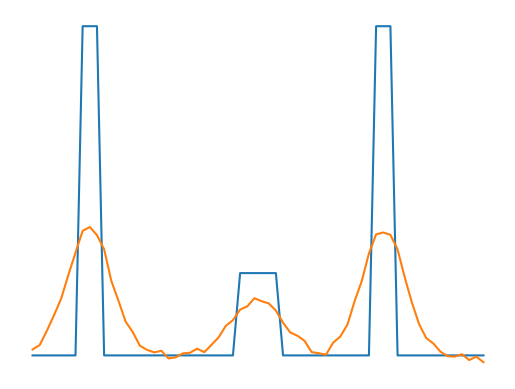

<Figure size 640x480 with 0 Axes>

In [2]:
D1D = Deblurring1D()
N = 64
n = N
A = D1D.forward_Op_matrix_1D(3, N)
# A = np.vstack((A, np.random.rand(3,N)))
x_true = D1D.gen_xtrue(N, test = 'piecewise')
b = A@x_true
(b, delta) = D1D.add_noise(b, 'Gaussian', 0.05)
plt.plot(x_true)
D1D.plot_data(b)
L = np.eye(A.shape[1])

In [3]:
Q_A, R_A, _ = operator_svd(A)
R_A = np.diag(R_A)

Q_L = Identity(A.shape[1])
R_L = Identity(A.shape[1])

In [38]:
def gcv_numerator_1(reg_param, Q_A, R_A, Q_L, R_L, b):

    # the observation term:

    R_A_2 = R_A.T @ R_A

    R_A_2 = R_A_2.todense() if isinstance(R_A_2, LinearOperator) else R_A_2

    # The regularizer term:

    R_L_2 = (R_L.T @ R_L)
    
    R_L_2 = R_L_2.todense() if isinstance(R_L_2, LinearOperator) else R_L_2

    # the inverse term:

    inverted = la.solve( ( R_A_2 + reg_param * R_L_2), (R_A.T @ Q_A.T @ b) )

    # times R_A, minus b, norm

    return np.linalg.norm( R_A @ inverted - Q_A.T @ b )

In [34]:
def gcv_numerator_2(reg_param, A, L, b):

    # the observation term:

    R_A_2 = A.T @ A

    # The regularizer term:

    R_L_2 = L.T @ L

    # the inverse term:

    inverted = la.solve( ( R_A_2 + reg_param * R_L_2), (A.T @ b) )

    # times R_A, minus b, norm

    return np.linalg.norm(A @ inverted - b )

In [5]:
def gcv_numerator_3(reg_param, Q_A, R_A, Q_L, R_L, b):

    # the observation term:

    R_A_2 = R_A.T @ R_A

    R_A_2 = R_A_2.todense() if isinstance(R_A_2, LinearOperator) else R_A_2

    # The regularizer term:

    R_L_2 = (R_L.T @ R_L)
    
    R_L_2 = R_L_2.todense() if isinstance(R_L_2, LinearOperator) else R_L_2

    # the inverse term:

    inverted = la.solve( ( R_A_2 + reg_param * R_L_2), (R_A.T @ Q_A.T @ b) )

    # times R_A, minus b, norm

    return np.sqrt((np.linalg.norm( R_A @ inverted - Q_A.T @ b ))**2 + np.linalg.norm(b - Q_A@(Q_A.T@b))**2)

In [ ]:
n1 = gcv_numerator_1(1e-2, Q_A, R_A, Q_L, R_L, b)
n2 = gcv_numerator_2(1e-2, A, Identity(A.shape[1]).todense(), b)
n3 = gcv_numerator_3(1e-2, Q_A, R_A, Q_L, R_L, b)

In [ ]:
print(n1)
print(n2)
print(n3)

In [ ]:
print(Q_A.shape)
print(b - Q_A@(Q_A.T@b)) # zeros because Q_A is square, not true in general; probably does not make much difference for our test problems
print(la.norm(b - Q_A@(Q_A.T@b)))

In [39]:
def gcv_denominator_1(reg_param, Q_A, R_A, Q_L, R_L, b):

    # the observation term:

    R_A_2 = R_A.T @ R_A

    R_A_2 = R_A_2.todense() if isinstance(R_A_2, LinearOperator) else R_A_2

    # The regularizer term:

    R_L_2 = (R_L.T @ R_L)

    R_L_2 = R_L_2.todense() if isinstance(R_L_2, LinearOperator) else R_L_2

    # the inverse term:

    inverted = la.solve( ( R_A_2 + reg_param * R_L_2), R_A.T )

    # trace term

    times_RA = R_A @ inverted

    Id = np.eye(times_RA.shape[0])

    trace_term = np.trace(Id - times_RA)

    return trace_term**2

In [33]:
def gcv_denominator_2(reg_param, A, L, b):

    # the observation term:

    R_A_2 = A.T @ A

    # The regularizer term:

    R_L_2 = (L.T @ L)

    # the inverse term:

    inverted = la.inv(( R_A_2 + reg_param * R_L_2))
    inverted = inverted @ A.T

    # trace term

    times_RA = A @ inverted

    Id = np.eye(A.shape[0])

    trace_term = np.trace(Id - times_RA)

    return trace_term**2

In [6]:
def gcv_denominator_3(reg_param, Q_A, R_A, Q_L, R_L, b):

    # the observation term:

    R_A_2 = R_A.T @ R_A

    R_A_2 = R_A_2.todense() if isinstance(R_A_2, LinearOperator) else R_A_2

    # The regularizer term:

    R_L_2 = (R_L.T @ R_L)

    R_L_2 = R_L_2.todense() if isinstance(R_L_2, LinearOperator) else R_L_2

    # the inverse term:

    inverted = la.solve( ( R_A_2 + reg_param * R_L_2), R_A.T@Q_A.T )

    # trace term

    times_RA = Q_A @ R_A @ inverted

    Id = np.eye(times_RA.shape[0])

    trace_term = np.trace(Id - times_RA)

    return trace_term**2

In [ ]:
d1 = gcv_denominator_1(1e-2, Q_A, R_A, Q_L, R_L, b)
d2 = gcv_denominator_2(1e-2, A, Identity(A.shape[1]).todense(), b)
d3 = gcv_denominator_3(1e-2, Q_A, R_A, Q_L, R_L, b)

In [ ]:
print(d1)
print(d2)
print(d3)

In [42]:
gcv_func_1 = lambda reg_param: gcv_numerator_1(reg_param, Q_A, R_A, Q_L, R_L, b) / gcv_denominator_1(reg_param, Q_A, R_A, Q_L, R_L, b)

In [ ]:
gcv_func_2 = lambda reg_param: gcv_numerator_2(reg_param, A, L, b) / gcv_denominator_2(reg_param, A, L, b)

In [7]:
gcv_func_3 = lambda reg_param: gcv_numerator_3(reg_param, Q_A, R_A, Q_L, R_L, b) / gcv_denominator_3(reg_param, Q_A, R_A, Q_L, R_L, b)

In [8]:
lambda_3 = op.fminbound(func = gcv_func_3, x1 = 1e-05, x2 = 1e2, args=(), xtol=1e-12, maxfun=1000, full_output=0, disp=1)
print(lambda_3)

0.0009529480778335119


In [9]:
lambdagcv = generalized_crossvalidation(A, b, L)
print(lambdagcv)

0.0009529480778335119


In [10]:
tikh_sol = lambda reg_param: np.linalg.lstsq(np.vstack((A, np.sqrt(reg_param)*L)), np.vstack((b.reshape((-1,1)), np.zeros((n,1)))))[0]
tikh_sol_gcv = tikh_sol(lambdagcv)

/var/folders/4h/_v_0ymh93tvgbx9z484yt3_00000gn/T/ipykernel_48884/3246165935.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  tikh_sol = lambda reg_param: np.linalg.lstsq(np.vstack((A, np.sqrt(reg_param)*L)), np.vstack((b.reshape((-1,1)), np.zeros((n,1)))))[0]


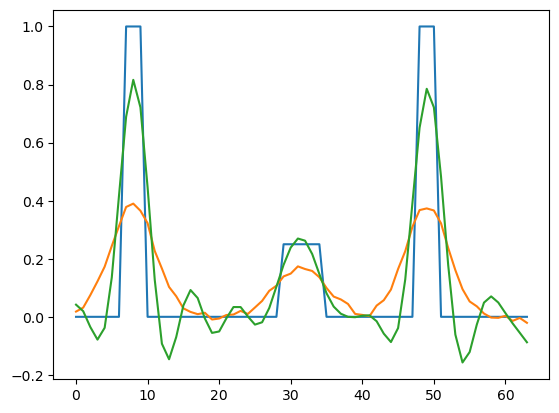

In [11]:
plt.plot(x_true)
plt.plot(b)
plt.plot(tikh_sol_gcv)

In [ ]:
out_lsqr = hybrid_lsqr(A, b.reshape((-1,1)), 20)

In [ ]:
print(out_lsqr[-1])

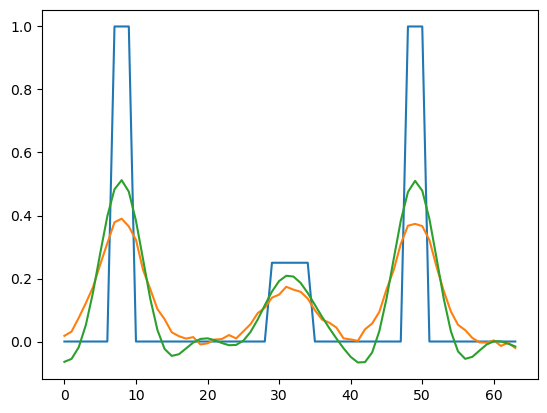

In [19]:
plt.plot(x_true)
plt.plot(b)
plt.plot(out_lsqr[0])

In [23]:
U = out_lsqr[1]
B = out_lsqr[2]
V = out_lsqr[3]

In [24]:
print(U.shape)
print(B.shape)
print(V.shape)

(64, 21)
(21, 20)
(64, 20)


In [30]:
B10 = B[:11,:10]
print(B10.shape)
U10 = U[:,:10]
print(U10.shape)
U11 = U[:,:11]
print(out_lsqr[-1][10])
bhat10 = U11.T @ b
print(bhat10)
L = np.eye(B10.shape[1])

(11, 10)
(64, 10)
99.99999760533561
[1.34943625e+00 5.96311195e-16 1.07032438e-15 1.04148461e-15
 9.69710423e-16 1.83447008e-15 4.70457007e-15 1.16634133e-14
 2.68530857e-14 3.59373989e-14 3.45166604e-14]


In [31]:
gcv_func_2 = lambda reg_param: gcv_numerator_2(reg_param, B10, L, bhat10) / gcv_denominator_2(reg_param, B10, L, bhat10)

In [36]:
gcv_func_2 = lambda reg_param: gcv_numerator_2(reg_param, B, np.eye(B.shape[1]), U.T@b) / gcv_denominator_2(reg_param, B, np.eye(B.shape[1]), U.T@b)

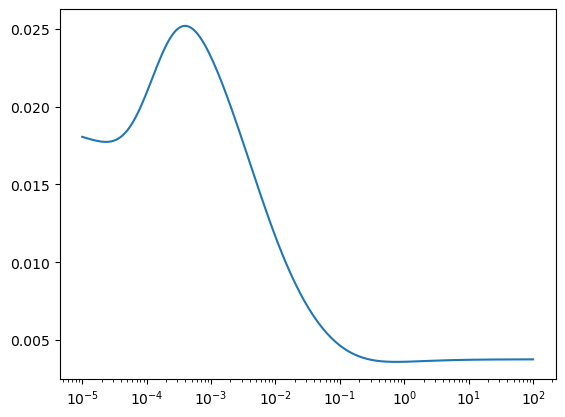

In [37]:
xx  = np.logspace(-5,2,200)
yy  = [gcv_func_2(val) for val in xx]
plt.semilogx(xx, yy)

In [50]:
Q_A, R_A, _ = operator_svd(B)
R_A = np.diag(R_A)

Q_L = Identity(B.shape[1])
R_L = Identity(B.shape[1])

In [51]:
gcv_func_1 = lambda reg_param: gcv_numerator_1(reg_param, Q_A, R_A, Q_L, R_L, U.T@b) / gcv_denominator_1(reg_param, Q_A, R_A, Q_L, R_L, U.T@b)

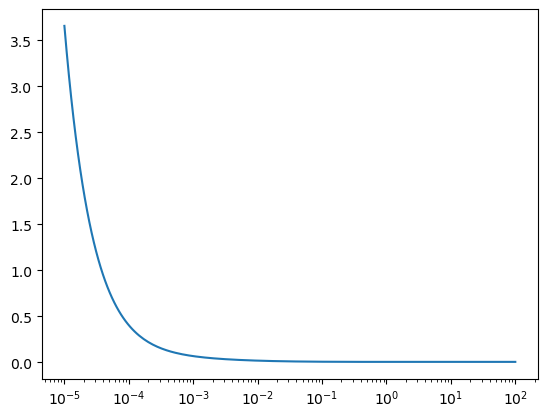

In [52]:
xx  = np.logspace(-5,2,200)
yy  = [gcv_func_1(val) for val in xx]
plt.semilogx(xx, yy)

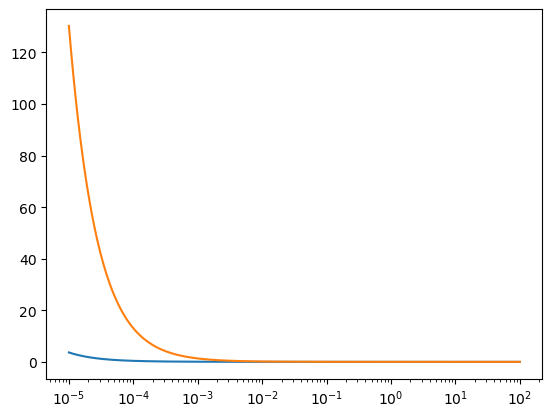

In [53]:
Q_A, R_A, _ = operator_svd(B10)
R_A = np.diag(R_A)

Q_L = Identity(B10.shape[1])
R_L = Identity(B10.shape[1])

gcv_func_1var = lambda reg_param: gcv_numerator_1(reg_param, Q_A, R_A, Q_L, R_L, U11.T@b) / gcv_denominator_1(reg_param, Q_A, R_A, Q_L, R_L, U11.T@b)

xx  = np.logspace(-5,2,200)
yyvar  = [gcv_func_1var(val) for val in xx]
plt.semilogx(xx, yy)
plt.semilogx(xx, yyvar)

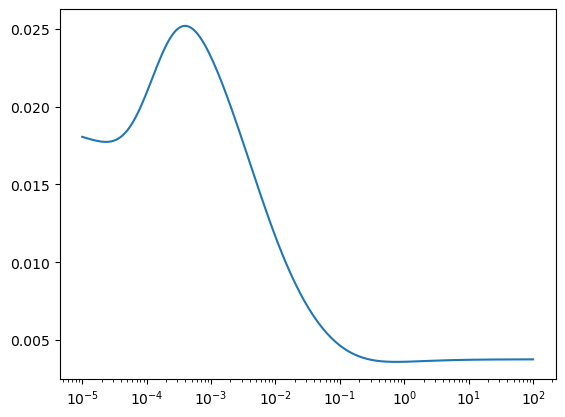

In [54]:
Q_A, R_A, _ = operator_svd(B)
R_A = np.diag(R_A)

Q_L = Identity(B.shape[1])
R_L = Identity(B.shape[1])

gcv_func_3 = lambda reg_param: gcv_numerator_3(reg_param, Q_A, R_A, Q_L, R_L, U.T@b) / gcv_denominator_3(reg_param, Q_A, R_A, Q_L, R_L, U.T@b)

xx  = np.logspace(-5,2,200)
yy  = [gcv_func_3(val) for val in xx]
plt.semilogx(xx, yy)